In [1]:
import autograd.numpy as np
import scipy as sp
from scipy.optimize import root
import matplotlib.pyplot as plt
import scipy.optimize as opt
import mpmath as mpm

In [45]:
%matplotlib notebook

# Bridgeman Mixing Rule

For mixing N species (according to wikipedia) the opacity of a spherical scatterer made up of n species of homogeniously mixed scatterers obbeys:
\begin{equation}
\sum_i\,\delta_i\,\frac{\sigma_i - \sigma_e}{\sigma_i + (n-1) \sigma_e}=0,
\end{equation}
where $\delta _{i}$ and $\sigma _{i}$ are respectively the fraction and the conductivity of each component, and 
$\sigma _{e}$ is the effective conductivity of the medium.


## Solving the equation

The problem is therefore is an optimisation problem, as all values but $\sigma _{e}$ are known. It should therefore be possible to find the root of the problem using N-R or a Metropolis algo MC-MC method (which may work better if the solution manifold has many local minima in $\mathbb{C}$ space).


#### Building the optimisation problem
All operations are done using numpy array broadcasts in hope that it will speed up the operation (see [numpy documentation](https://numpy.org/devdocs/user/basics.broadcasting.html) for reference). ```sigma``` is the conductivity array, ```delta``` is the mass fraction array,  and ```sigma_eff``` is the unknown, the effective conductivity.

In [2]:
def SumFunc_Generic(delta,sigma,sigma_eff):
    n=len(delta)
    return np.sum(delta*(sigma-sigma_eff)/(sigma+((n-1)*sigma_eff)))

In [3]:
def makeProblem(delta_array,sigma_array):
    f=lambda sigma_e : SumFunc_Generic(delta_array,sigma_array,sigma_e)
    return f

The function ```makeProblem(delta_array,sigma_array)``` takes ```delta``` and  ```sigma``` and returns a lambda function ``` f(sigma_e)=SumFunc_Generic(delta=delta_array,sigma=sigma_array,sigma_e)```. This will make setting up the optimisation problem easier.

#### Reading in the opacity tables
Opacity values are read into complex arrays

In [94]:
data=np.loadtxt("new_cons/Normal_silicates/n_olivine.dat")
n_olivine=data[:,1]+1j*data[:,2]
data=np.loadtxt("new_cons/Normal_silicates/n_orthopyroxene.dat")
n_pyroxene=data[:,1]+1j*data[:,2]
data =np.loadtxt("new_cons/Normal_silicates/n_iron.dat")
n_iron =data[:,1]+1j*data[:,2]
data =np.loadtxt("new_cons/Normal_silicates/n_troilite.dat")
n_troilite =data[:,1]+1j*data[:,2]
data =np.loadtxt("new_cons/Normal_silicates/n_volatile_organics.dat")
n_organics =data[:,1]+1j*data[:,2]
data =np.loadtxt("new_cons/Normal_silicates/n_water_ice.dat")
n_Water_ice=data[:,1]+1j*data[:,2]
lambda_k= data[:,0]*1e-4
nu=(sp.constants.speed_of_light*1e2)/lambda_k

In [95]:
data= np.loadtxt("semenov.dat",dtype = np.float128)
nusem= data[:,0]
Kappasem= data[:,1]

#### Reading in the abundancy values

In [96]:
import functions_op as fop

In [97]:
dict_nrm=fop.dic_comp('NRM')

In [98]:
frac_olivine=dict_nrm["frac_olivine"]
frac_iron=dict_nrm["frac_iron"]
frac_pyroxene=dict_nrm["frac_pyroxene"]
frac_organics=dict_nrm["frac_organics"]
frac_Troilite=dict_nrm["frac_Troilite"]
frac_Water_ice=dict_nrm["frac_Water_ice"]

rho_olivine=dict_nrm["dens_olivine"]
rho_iron=dict_nrm["dens_iron"]
rho_pyroxene=dict_nrm["dens_pyroxene"]
rho_organics=dict_nrm["dens_organics"]
rho_Troilite=dict_nrm["dens_Troilite"]
rho_Water_ice=dict_nrm["dens_Water_ice"]

#### Making the arrays be of the correct shape

In [99]:
Frac_array= np.asarray([frac_olivine,frac_iron,frac_pyroxene,frac_organics,frac_Troilite,frac_Water_ice])
sigma_array=np.asarray([n_olivine,n_pyroxene,n_iron,n_troilite,n_organics,n_Water_ice])

In [100]:
sigma_array[:,0]

array([1.6512+0.011699j , 1.5921+0.0040824j, 1.4453+0.89017j  ,
       4.2529+0.75934j  , 1.3014+0.86125j  , 1.2576+0.078691j ])

#### Solver
Uses the autograd package to speed up the gradient descent method by providing gradient functions.

In [101]:
import autograd as ag

In [107]:
for i in range(len(n_mixture)):
    f=makeProblem(Frac_array,sigma_array[:,i])
    #f_prime=ag.holomorphic_grad(f) #for solvers using the analytic derivative
    mixture=mpm.findroot(f,x0=1.0+1.0j)
    n_mixture[i]=mixture

In [108]:
ee1 = fop.e1(np.real(n_mixture),np.imag(n_mixture))
ee2 = fop.e2(np.real(n_mixture),np.imag(n_mixture))
xdust=fop.xj(lambda_k,1e-5,1e-5)
Hdust=fop.Hj(xdust,ee1,ee2)
sigma= fop.sigmajk(lambda_k,ee1,ee2,0.333333333)
Kappadust=fop.Kappaj(1e-2,3.0,Hdust,sigma,sigma,sigma)


<IPython.core.display.Javascript object>


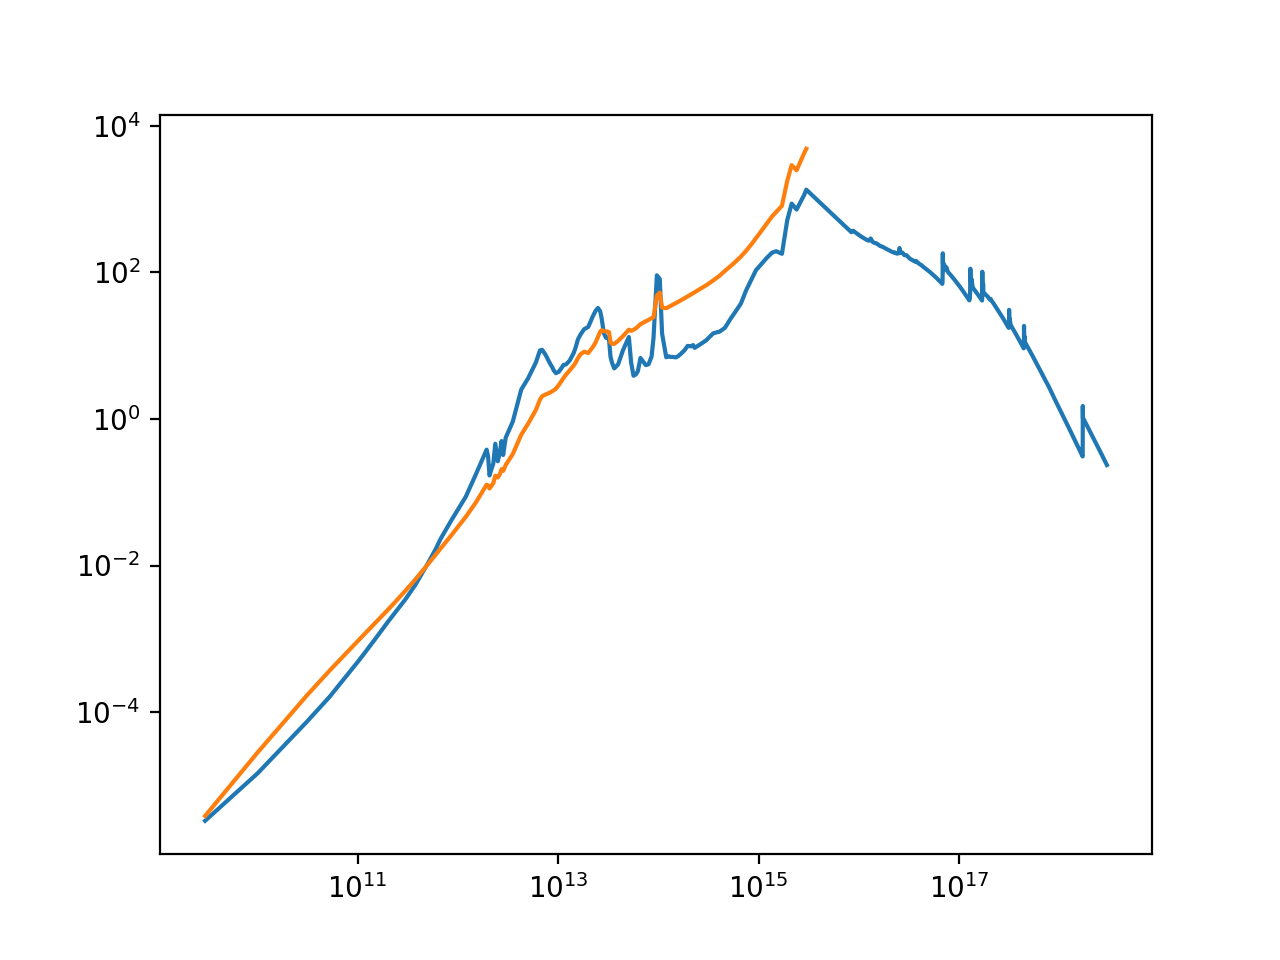

In [105]:
plt.figure()
plt.loglog(nusem,Kappasem)
plt.loglog(nu,Kappadust)